In [24]:
from amm import amm
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
# plt.style.use('paper.mplstyle')

import seaborn as sns
sns.set_theme(style="ticks")

import statsmodels.api as sm
import matplotlib.ticker as mtick
import pickle

In [150]:
T = 60
Rx = 100.
Ry = 1000.
batch_size = 1_000

kappa = [0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
sigma = [1, 0.3, 0.5, 1.5, 1.75, 2, 2.25]
p = [0.35, 0.3, 0.34, 0.33, 0.32, 0.31, 0.3]
phi = np.array([0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03])

In [151]:
''' Initial reserves '''
Rx0   = np.repeat(Rx, len(kappa))
Ry0   = np.repeat(Ry, len(kappa))

pools = amm(Rx=Rx0, Ry=Ry0, phi=phi)

xs_0 = np.repeat(1., len(kappa))
l = pools.swap_and_mint(xs_0)
end_pools, Rx_t, Ry_t, v_t, event_type_t, event_direction_t = pools.simulate(kappa, p, sigma, T=T, batch_size=batch_size)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.56it/s]


In [152]:
x_T = np.array([pool.burn_and_swap(l) for pool in end_pools])
log_ret = np.log(x_T)
Y = pd.DataFrame(log_ret)
Y

,0,1,2,3,4,5,6
0,0.160542,0.056404,0.242278,0.072361,0.076491,0.343009,-0.009291
1,0.167887,0.058166,0.627765,0.035338,0.018291,0.135556,0.015490
2,0.119652,-0.023229,0.020969,-0.061471,0.008222,-0.084056,-0.094814
3,0.114707,0.075219,0.322061,0.014805,0.000372,0.052629,-0.044421
4,0.185891,0.077953,0.051646,0.421408,0.101421,0.169106,0.064178
...,...,...,...,...,...,...,...
995,0.198295,0.124590,0.122981,0.062572,0.166792,0.092676,0.087451
996,0.123134,0.157537,0.103651,0.235614,0.164821,0.249644,0.062077
997,0.072198,0.130771,0.212893,0.014142,0.112474,0.066137,0.001815
998,0.137506,0.156827,0.279192,0.059636,0.095322,0.188603,0.039688


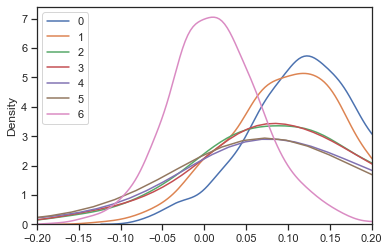

In [154]:
for i in range(log_ret.shape[1]):
    sns.kdeplot(log_ret[:, i], label=i)
    
plt.xlim((-0.2, 0.2))
plt.legend()

# Portfolio optimization

In [155]:
import riskfolio as rp
import pandas as pd

In [156]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'CVaR' # Risk measure used, this time will be variance
obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,0,1,2,3,4,5,6
weights,0.529259,0.265938,0.086156,0.0475,0.04057,0.030577,3.138133e-14


<AxesSubplot:ylabel='Density'>

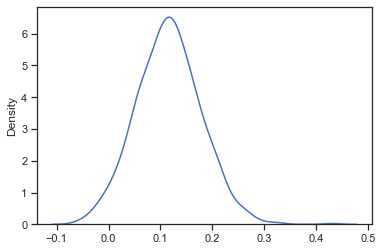

In [167]:
portfolio_returns = log_ret @ w
sns.kdeplot(portfolio_returns.to_numpy().T[0])